# Реализация детекции текста с помощью модели Fast-RCNN

In [17]:
import os
import PIL
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

from torch.utils.tensorboard import SummaryWriter

In [18]:
from MyDataset import MyDataset

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor,MaskRCNN


      
def get_instance_segmentation_model(num_classes) -> MaskRCNN:
    # load an instance segmentation model pre-trained on COCO
    #model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=False,num_classes = num_classes)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    #in_features_mask = model.roi_heads.box_predictor.cls_score.in_channels
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    #model.roi_heads.box_predictor = MaskRCNNPredictor(in_features_mask,
                                                      #in_features, num_classes)

    # now get the number of input features for the mask classifier
    # in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # hidden_layer = 256
    # and replace the mask predictor with a new one
    # model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
    #                                                    hidden_layer,
    #                                                    num_classes)
    model.roi_heads.mask_predictor  = None

    return model

In [20]:
from common.engine import train_one_epoch
from common import utils
import common.transforms as T


def get_transform(train):
    transforms = []
    #transforms.Lambda(lambda image: image.convert("RGB")),
    #transforms.ConvertImageDtype(torch.float),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # converts the image, a PIL image, into a PyTorch Tensor
    #transforms.append(T.torchvision.transforms.PILToTensor())
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [21]:
conf_train = {
        'fonts':['TextRecognitionDataGenerator/tests/font.ttf']
        , 'texts':['Привет Мир!!!!\nПока мир!\nввв','dfdsfsd','вот так']
        , 'text_colors':['#00ffff','#ff0000','#ffff00']
        , 'size_images':[(280,280),(512,512)]
        , 'position_texts':[(20,40),(2,4),(10,4),(4,10),(40,50)]
        , 'font_sizes':[32,16,10]
        , 'background_colors':['#000000','#ffffff']
    }
dataset = MyDataset(conf_train, get_transform(train=True))
dataset_test = MyDataset(conf_train, get_transform(train=False))

# split the dataset in train and test set
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

for d in data_loader:
    break

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
#не сработало:
# optimizer = torch.optim.Adam(params, lr=0.005,
#                             weight_decay=0.0005)
#не сработало:
#optimizer = torch.optim.Adam(params, lr=0.05)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/home/aleksei/.virtualenvs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksei/.virtualenvs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:

# let's train it for 10 epochs
num_epochs = 100

writer = SummaryWriter('data')

def collback_loss(loss_value,step):
    #print(f'{loss_value=}')
    writer.add_scalar('Loss/trainSGD100', loss_value,step)

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10,collback_loss=collback_loss)
    # update the learning rate
    lr_scheduler.step()
    
writer.close()

Epoch: [0]  [  0/270]  eta: 0:02:04  lr: 0.000024  loss: 1.4713 (1.4713)  loss_classifier: 0.9391 (0.9391)  loss_box_reg: 0.0117 (0.0117)  loss_objectness: 0.4837 (0.4837)  loss_rpn_box_reg: 0.0367 (0.0367)  time: 0.4617  data: 0.1924  max mem: 4270
Epoch: [0]  [ 10/270]  eta: 0:01:09  lr: 0.000209  loss: 1.6489 (2.0311)  loss_classifier: 0.6314 (0.6006)  loss_box_reg: 0.0416 (0.0598)  loss_objectness: 0.6468 (1.0785)  loss_rpn_box_reg: 0.0923 (0.2922)  time: 0.2687  data: 0.0192  max mem: 4535
Epoch: [0]  [ 20/270]  eta: 0:01:04  lr: 0.000395  loss: 0.6481 (1.2634)  loss_classifier: 0.2029 (0.3660)  loss_box_reg: 0.0776 (0.0772)  loss_objectness: 0.1662 (0.6176)  loss_rpn_box_reg: 0.0895 (0.2027)  time: 0.2493  data: 0.0020  max mem: 4535
Epoch: [0]  [ 30/270]  eta: 0:01:01  lr: 0.000581  loss: 0.2846 (0.9372)  loss_classifier: 0.0839 (0.2676)  loss_box_reg: 0.0797 (0.0734)  loss_objectness: 0.0645 (0.4292)  loss_rpn_box_reg: 0.0657 (0.1669)  time: 0.2496  data: 0.0023  max mem: 4535


In [28]:
torch.cuda.empty_cache()

In [35]:
!ls -s model.mw

161828 model.mw


In [24]:
torch.save(model.state_dict(), 'model.mw')

In [25]:
to_image = torchvision.transforms.ToPILImage()
import matplotlib.pyplot as plt
import cv2
import numpy as np

predict=[{'boxes': tensor([[ 20.1573, 135.7584,  74.1445, 161.2782],
        [ 20.3210,  92.9547, 178.4447, 125.5436],
        [ 21.3857,  49.5335, 247.4615,  83.0610]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.9993, 0.9992], device='cuda:0', grad_fn=<IndexBackward0>)}]


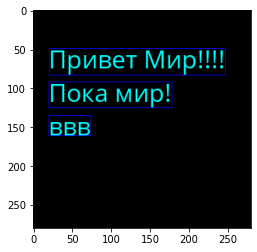

predict=[{'boxes': tensor([[ 20.4648,  71.5514,  98.5967,  84.1635],
        [ 20.0939,  49.9092, 130.2473,  61.5864],
        [ 20.0602,  93.9673,  47.1647, 101.7030]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9996, 0.9989], device='cuda:0', grad_fn=<IndexBackward0>)}]


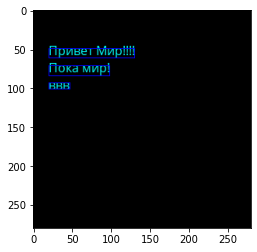

predict=[{'boxes': tensor([[18.9362, 49.9836, 94.0407, 53.0698],
        [19.1987, 62.9728, 68.9261, 65.9604],
        [20.1556, 76.0352, 37.8519, 77.0478],
        [20.0503, 75.7747, 38.0268, 76.5553],
        [19.4169, 61.5209, 69.3392, 67.6623],
        [19.5347, 75.3252, 37.9536, 76.3262]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9853, 0.9733, 0.9639, 0.9054, 0.1242, 0.1014], device='cuda:0',
       grad_fn=<IndexBackward0>)}]


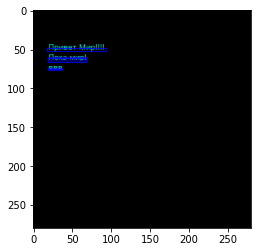

predict=[{'boxes': tensor([[  2.6660,  99.7798,  55.5273, 125.0821],
        [  1.8332,  57.4276, 162.3230,  89.9149],
        [  4.4345,  13.9769, 227.4174,  47.0578]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9992, 0.9990], device='cuda:0', grad_fn=<IndexBackward0>)}]


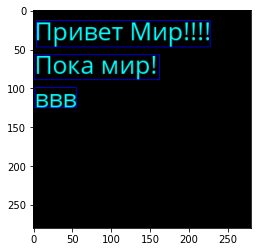

predict=[{'boxes': tensor([[  0.9917,  14.0009, 112.0671,  25.7663],
        [  2.0343,  35.9326,  80.2734,  48.3438],
        [  1.6433,  57.8896,  28.7409,  66.0758]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.9997, 0.9991], device='cuda:0', grad_fn=<IndexBackward0>)}]


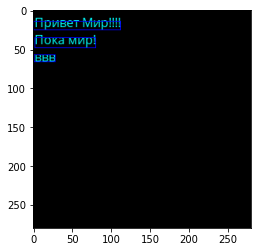

predict=[{'boxes': tensor([[ 1.7456, 27.0750, 51.1758, 29.9521],
        [ 1.8475, 14.0819, 74.1703, 16.9790],
        [ 1.9545, 40.0728, 19.9860, 41.2552],
        [ 1.6850, 39.5923, 20.2484, 40.7610],
        [ 0.0000, 25.2774, 53.6073, 30.7123],
        [ 0.9741, 11.9019, 74.8555, 17.9076]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9789, 0.9688, 0.9353, 0.4013, 0.2364, 0.1797], device='cuda:0',
       grad_fn=<IndexBackward0>)}]


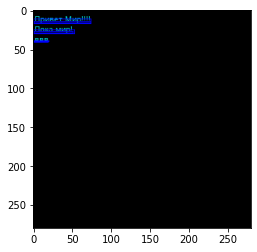

predict=[{'boxes': tensor([[  9.8778,  99.8758,  63.9706, 124.9552],
        [  9.5333,  56.9698, 170.5411,  89.9317],
        [ 10.0746,  13.5160, 236.5048,  47.0587]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.9992, 0.9989], device='cuda:0', grad_fn=<IndexBackward0>)}]


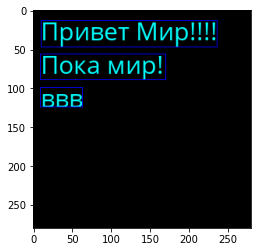

predict=[{'boxes': tensor([[  9.4407,  14.1288, 121.0633,  25.8571],
        [  9.7136,  36.0745,  89.1335,  48.1730],
        [  9.9965,  58.0951,  37.1909,  65.9034]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.9997, 0.9988], device='cuda:0', grad_fn=<IndexBackward0>)}]


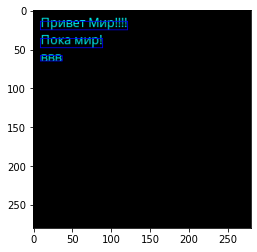

predict=[{'boxes': tensor([[10.3671, 27.1142, 59.1043, 29.9210],
        [11.5279, 14.0055, 81.8681, 16.9073],
        [10.0083, 40.2649, 27.7717, 41.2070],
        [10.0252, 39.8650, 27.9468, 40.9097],
        [10.5648, 11.7957, 82.0311, 17.7911]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9856, 0.9621, 0.9393, 0.8691, 0.1365], device='cuda:0',
       grad_fn=<IndexBackward0>)}]


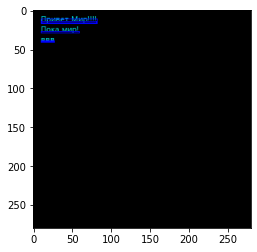

predict=[{'boxes': tensor([[  4.0749, 106.1273,  57.7316, 130.8228],
        [  6.2698,  63.2751, 162.4233,  95.9543],
        [  2.2098,  20.3286, 230.4179,  52.5747]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9994, 0.9987], device='cuda:0', grad_fn=<IndexBackward0>)}]


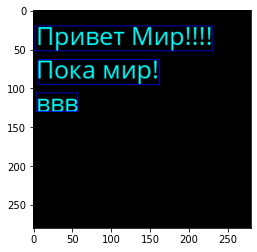

predict=[{'boxes': tensor([[  3.7457,  20.0467, 114.2224,  31.8933],
        [  3.5247,  42.1657,  82.1642,  53.9500],
        [  4.0676,  63.9626,  31.0230,  72.0035]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9995, 0.9988], device='cuda:0', grad_fn=<IndexBackward0>)}]


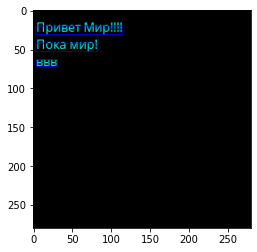

predict=[{'boxes': tensor([[ 5.3651, 19.9125, 75.1818, 23.0294],
        [ 4.2945, 32.9731, 52.6301, 36.0608],
        [ 3.5941, 46.0966, 21.6559, 47.0820],
        [ 4.0464, 46.4429, 22.0002, 47.3589],
        [ 3.3778, 45.6955, 21.1250, 46.7002],
        [ 2.5583, 18.7354, 77.9284, 24.6417]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9823, 0.9746, 0.9025, 0.7251, 0.2775, 0.2072], device='cuda:0',
       grad_fn=<IndexBackward0>)}]


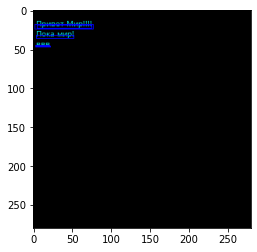

In [27]:
model.eval()


for i,(x,y) in enumerate(data_loader_test):
    img = to_image(x[0])
    x = x[0].to(device)
    predict = model([x])
    #img = np.asarray(img)
    # for box in y[0]['boxes']:
    # #box = y[0]['boxes'].view(-1)
    #     x1 = int(box[0])
    #     y1 = int(box[1])
    #     x2 = int(box[2])
    #     y2 = int(box[3])        
    #     img = cv2.rectangle(np.asarray(img),(x1,y1),(x2,y2),color=(255,0,0))
    print(f'{predict=}')
    for box in predict[0]['boxes']:
    #box = y[0]['boxes'].view(-1)
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])        
        img = cv2.rectangle(np.asarray(img),(x1,y1),(x2,y2),color=(0,0,255))
    #print(img.shape)
    plt.imshow(img)
    plt.show()
    #img.show()
    if i>10:
        break